# Out-of-the-box PCA Workflow

**Start:** You cleaned the data and want to inpsect its properties by applying PCA.

**End:** Scree plot, factor loadings, Kmeans clustering, plotting PCs grouped by kmean's labels.  PCA's factor loadings highlight dimensions that cover most of the variance.

In [1]:
import pandas as pd
import numpy as np
import io #parse from url
import requests #load from url
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
# from sklearn.metrics import confusion_matrix, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
print("RUNNING ON")
!python --version
print('Pandas ',pd.__version__)
print('Seaborn ',sns.__version__)

RUNNING ON
Python 3.7.6Pandas 
 1.0.3
Seaborn  0.10.0


#### Load data, ensure:
* numeric features
* cleaned DF (no missings)

**Example dataset:** 

Replication data from a behavioral economic experiment in Turkish schools. 

Alan, Sule; Boneva, Teodora; Ertac, Seda, 2019, "Replication Data for: 'Ever Failed, Try Again, Succeed Better: Results from a Randomized Educational Intervention on Grit'", https://doi.org/10.7910/DVN/SAVGAL, Harvard Dataverse, V1.

In [225]:
#load data from URL
url = 'https://dataverse.harvard.edu/api/access/datafile/3352340?gbrecs=false'
s=requests.get(url).content
df_raw = pd.read_csv(io.StringIO(s.decode('utf-8')), sep='\t')
df = df_raw.copy()

#select features
selected_features = ['grit', 'male', 'task_ability', 'raven', 'grit_survey1', 
 'belief_survey1', 'mathscore1', 'verbalscore1', 'risk', 'inconsistent']
X_raw = df.filter(selected_features, axis='columns')

#impute with mean 
imp = SimpleImputer()
X = imp.fit_transform(X_raw)

## Main method

In [226]:
#standardize 
std_scaler = StandardScaler()
X_std = std_scaler.fit_transform(X)

#compute PCs
pca = PCA()
X_pca = pca.fit_transform(X_std)

In [256]:
n_components = len(pca.explained_variance_ratio_)
vals = pca.explained_variance_ratio_
cumvals = np.cumsum(vals)
idx = np.arange(n_components)+1

df_explained_variance = pd.DataFrame([vals, cumvals], index=['explained variance', 'cumulative'], columns=idx).T
print('Principal components')
print('-'*40)
print(df_explained_variance.head(20))
print('-'*40)

mean_explained_variance = df_explained_variance.iloc[:,0].mean()
print('Mean explained variance:', round(mean_explained_variance,3))

Principal components
----------------------------------------
    explained variance  cumulative
1             0.265261    0.265261
2             0.122700    0.387962
3             0.113990    0.501951
4             0.099139    0.601090
5             0.094357    0.695447
6             0.083412    0.778859
7             0.063117    0.841976
8             0.056386    0.898362
9             0.052588    0.950950
10            0.049050    1.000000
----------------------------------------
Mean explained variance: 0.1


Do you want to limit the DF? (y/n) > n


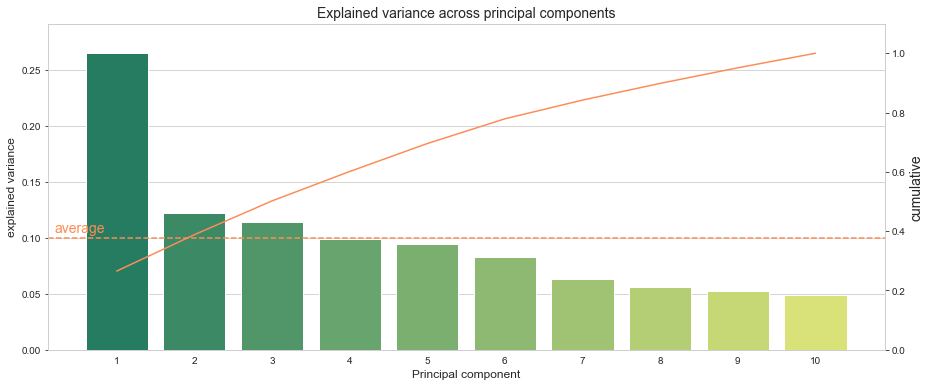

In [254]:
#limit to x PC
limit = input("Do you want to limit the DF? (y/n) > ")
if limit == 'y':
    limit_df = int(input("Zoom in onto the first x PC > "))
else:
    limit_df = len(df_explained_variance)

df_explained_variance_limited = df_explained_variance.iloc[:limit_df,:]


#make scree plot
fig, ax1 = plt.subplots(figsize=(15,6))

ax1.set_title('Explained variance across principal components', fontsize=14)
ax1.set_xlabel('Principal component', fontsize=12)
ax1.set_ylabel('Explained variance', fontsize=12)

ax2 = sns.barplot(x=idx[:limit_df], y='explained variance', data=df_explained_variance_limited, palette='summer')
ax2 = ax1.twinx()
ax2.grid(False)

ax2.set_ylabel('Cumulative', fontsize=14)
ax2 = sns.lineplot(x=idx[:limit_df]-1, y='cumulative', data=df_explained_variance_limited, color='#fc8d59')

ax1.axhline(mean_explained_variance, ls='--', color='#fc8d59') #plot mean
ax1.text(-.8, mean_explained_variance+(mean_explained_variance*.05), "average", color='#fc8d59', fontsize=14) #label y axis

max_y1 = max(df_explained_variance_limited.iloc[:,0])
max_y2 = max(df_explained_variance_limited.iloc[:,1])
ax1.set(ylim=(0, max_y1+max_y1*.1))
ax2.set(ylim=(0, max_y2+max_y2*.1))

plt.show()

#### Set parameters

In [3]:
testmode = True #choose sample share and select K with elbow method
sample_share = 0.4 #choose lower for larger data

In [ ]:
if sample_size != 1:
    print("Sampling from data")
    n_sample = X_pca.shape[0]*sample_share
    idx = np.random.randint(X_pca.shape[0], size=n_sample)
    X_pca_sample = X_pca[idx,:]
    print(f"--> Sample has shape {X_pca_sample.shape}")